In [3]:
%pip install rasterio
%pip install bmi_topography
import config

  Using cached rasterio-1.4.3.tar.gz (442 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [2 lines of output]
      INFO:root:Building on Windows requires extra options to setup.py to locate needed GDAL files. More information is available in the README.
      ERROR: A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
ERROR: Failed to build 'rasterio' when getting requirements to build wheel


  Using cached bmi_topography-0.9.0-py3-none-any.whl.metadata (13 kB)
  Using cached xarray-2025.11.0-py3-none-any.whl.metadata (12 kB)
  Using cached rioxarray-0.20.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached bmipy-2.0.1-py3-none-any.whl.metadata (2.7 kB)
  Using cached black-25.11.0-cp314-cp314-win_amd64.whl.metadata (85 kB)
  Using cached mypy_extensions-1.1.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached pathspec-0.12.1-py3-none-any.whl.metadata (21 kB)
  Using cached pytokens-0.3.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached rasterio-1.4.3.tar.gz (442 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [2 lines of output]
      INFO:root:Building on Windows requires extra options to setup.py to locate needed GDAL files. More information is available in the README.
      ERROR: A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
ERROR: Failed to build 'rasterio' when getting requirements to build wheel


# Fonctions
* save_tiff - pour sauvegarder les requests en tant que .tiff
* tiff_to_png - extraction du .tiff et transformation vers .png, et prend aussi la metadata.

In [ ]:
def calculate_distance(lat1, lon1, lat2, lon2):
    point1 = (lat1, lon1)
    point2 = (lat2, lon2)
    return round(geodesic(point1, point2).m,0)

In [ ]:
def save_tiff(response, file_title):
  # Assuming the response is an image in bytes
  image_data = response.content

  # You can save the data to a file
  with open(file_title, "wb") as f:
      f.write(image_data)

  print("Data successfully saved to output_image.tiff")

In [ ]:
import rasterio
import numpy as np
import imageio
from geopy.distance import geodesic

def tiff_to_png(file_title, central_lat, central_lon, height, width):
    # Open the GeoTIFF file
    with rasterio.open(file_title + '.tiff') as src:

        # print some info
        print('Profile:', src.profile)
        print('Scales:', src.scales)
        print('Offset:', src.offsets)
        print('Data type:', src.dtypes)
        print('Nodata value:', src.nodata)
        print('CRS:', src.crs)
        print('Unit:', 'meters' if src.crs.is_projected else 'degree')
        print('Cell dx:', src.transform.a)
        print('Cell dy:', src.transform.e)
        print('Transform:', src.transform)
        print("Raster dims:", src.width, src.height)

        # Read the first band (elevation data is typically stored in the first band)
        elevation_data = (src.read(1).astype(np.float32) * src.scales + src.offsets).astype(np.float32)
        print('Elevs range:', elevation_data.min(), elevation_data.max())

        # Get min and max elevation values
        hmin = elevation_data.min()
        hmax = elevation_data.max()

        # Example: assign min height to nodata cells to avoid messing the range
        nodataMask = elevation_data == src.nodata
        elevation_data[nodataMask] = hmin
        print('Nodata cells:', np.sum(nodataMask))

        # Normalize to 0-65535 range for 16-bit PNG
        if hmax == hmin:
            elevation_data = np.zeros_like(elevation_data, dtype=np.uint16)
        else:
            elevation_data = (elevation_data - hmin) / (hmax - hmin)
            elevation_data = (elevation_data * 65535).astype(np.uint16)
        filename = file_title + ".png"
        imageio.imwrite(filename, elevation_data)

        with open("presets.txt", "a") as f:
            data_string = "\"" + file_title + "\", " + "\"terrains/" + file_title + ".png\", " + str(src.width) + ", " + str(src.height) + ", " + str(height) + ", " + str(width) + ", " + str(hmin) + ", " + str(hmax) + ", " + str(central_lat) + ", 1.0" + "\n"
            f.write(data_string)

        print(f"Saved normalized DEM as {filename}")

In [ ]:
import requests
import json
from geopy.distance import geodesic
import numpy as np

south_start = 45#44
north_end = 46#50
west_start = 1#0
east_end = 2#8
grid_size = 0.5

# Delete presets.txt file
with open("presets.txt", "w") as f:
    f.write("")

# Calculate distance in meters
height = calculate_distance(south_start, west_start, north_end, west_start)
width = calculate_distance(south_start, west_start, south_start, east_end)

# Create a list to store bounding boxes for each grid cell
grid_bboxes = []
for lat in np.arange(south_start, north_end, grid_size):
    for lon in np.arange(west_start, east_end, grid_size):
        south = lat
        north = min(lat + grid_size, north_end)
        west = lon
        east = min(lon + grid_size, east_end)
        grid_bboxes.append({'south': south, 'north': north, 'west': west, 'east': east})

# Iterate through the grid bounding boxes and fetch data for each
for bbox in grid_bboxes:
    south = bbox['south']
    north = bbox['north']
    west = bbox['west']
    east = bbox['east']

    # Calculate central latitude and longitude
    central_lat = (south + north) / 2
    central_lon = (west + east) / 2

    res = requests.get('https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&south=' + str(south) + '&north='+ str(north) + '&west=' + str(west) + '&east=' + str(east) + '&outputFormat=GTiff&API_Key=1fc4ee7d40b9cd74956d78aec128e2d5')
    file_name = f"output_image_{south}_{north}_{west}_{east}.tiff"
    save_tiff(res, file_name)
    print(f"Processed bbox: South={south}, North={north}, West={west}, East={east}")

    tiff_to_png(f"output_image_{south}_{north}_{west}_{east}", central_lat, central_lon, height, width)

Data successfully saved to output_image.tiff
Processed bbox: South=45.0, North=45.5, West=1.0, East=1.5
Profile: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 1800, 'height': 1800, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0002777777777778146, 0.0, 0.9998611111350897,
       0.0, -0.0002777777777778146, 45.500138888886966), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
Scales: (1.0,)
Offset: (0.0,)
Data type: ('int16',)
Nodata value: -32768.0
CRS: EPSG:4326
Unit: degree
Cell dx: 0.0002777777777778146
Cell dy: -0.0002777777777778146
Transform: | 0.00, 0.00, 1.00|
| 0.00,-0.00, 45.50|
| 0.00, 0.00, 1.00|
Ra

# Copernicus

* Authentification
* Premier essai avec extraction du .png
* Deuxieme essai avec extraction du .tiff vers png

In [ ]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Your client credentials
client_id = 'sh-a114c80e-b692-4700-83f2-749260bca672'
client_secret = config.client_secret

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")

In [ ]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["DEM"],
    output: { bands: 1 },
  }
}

function evaluatePixel(sample) {
  return [sample.DEM / 1000]
}
"""

request = {
    "input": {
        "bounds": {
            "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
            "bbox": [
                13.822174072265625,
                45.85080395917834,
                14.55963134765625,
                46.29191774991382,
            ],
        },
        "data": [
            {
                "type": "dem",
                "dataFilter": {"demInstance": "COPERNICUS_30"},
                "processing": {
                    "upsampling": "BILINEAR",
                    "downsampling": "BILINEAR",
                },
            }
        ],
    },
    "output": {
        "width": 512,
        "height": 512,
        "responses": [
            {
                "identifier": "default",
                "format": {"type": "image/png"},
            }
        ],
    },
    "evalscript": evalscript,
}

url = "https://sh.dataspace.copernicus.eu/api/v1/process"
response = oauth.post(url, json=request)
save_tiff(response, "output_image.tiff")

Data successfully saved to output_image.tiff


In [ ]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["DEM"],
    output: { bands: 1 },
  }
}

function evaluatePixel(sample) {
  return [sample.DEM / 1000]
}
"""

request = {
    "input": {
        "bounds": {
            "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
            "bbox": [
                13.822174072265625,
                45.85080395917834,
                14.55963134765625,
                46.29191774991382,
            ],
        },
        "data": [
            {
                "type": "dem",
                "dataFilter": {"demInstance": "COPERNICUS_30"},
                "processing": {
                    "upsampling": "BILINEAR",
                    "downsampling": "BILINEAR",
                },
            }
        ],
    },
    "output": {
        "resx": 0.0003,
        "resy": 0.0003,
        "responses": [
            {
                "identifier": "default",
                "format": {"type": "image/tiff"},
            }
        ],
    },
    "evalscript": evalscript,
}

url = "https://sh.dataspace.copernicus.eu/api/v1/process"
response = oauth.post(url, json=request)
save_tiff(response, "output_image.tiff")

Data successfully saved to output_image.tiff


# Open Topography

/usr/local/lib/python3.12/dist-packages/bmi_topography/api_key.py:49: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.csdms.io/en/latest/#api-key for more information.
  warnings.warn(


https://portal.opentopography.org/API/globaldem?demtype=SRTMGL3&south=39.93&north=40.0&west=-105.33&east=-105.26&outputFormat=GTiff&API_Key=demoapikeyot2022
<xarray.DataArray 'spatial_ref' ()> Size: 8B
array(0)
Coordinates:
    spatial_ref  int64 8B 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    horizontal_datum_name:        World Geodetic System 1984
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -105.33041666668363 0.000833333333333144 0....


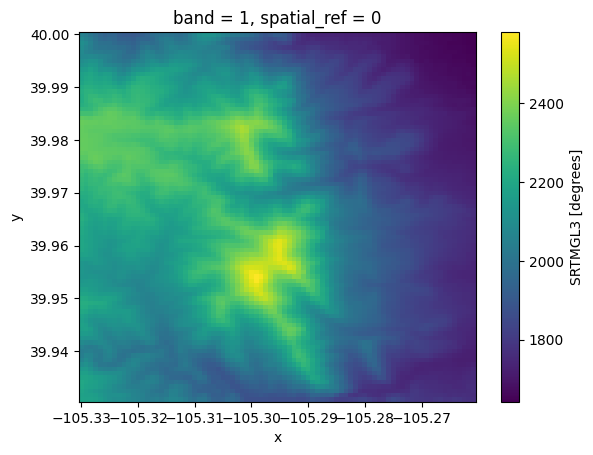

In [ ]:
import matplotlib.pyplot as plt

from bmi_topography import Topography

params = Topography.DEFAULT.copy()
params["south"] = 39.93
params["north"] = 40.00
params["west"] = -105.33
params["east"] = -105.26

boulder = Topography(**params)

print(boulder.url)

boulder.fetch()
boulder.load()

print(boulder.da.spatial_ref)

boulder.da.plot()
plt.show()

# Automated extraction

In [ ]:
import requests
import json
from geopy.distance import geodesic
import numpy as np

south_start = 44
north_end = 45#50
west_start = -1
east_end = 0#8
grid_size = 0.5

# Create a list to store bounding boxes for each grid cell
grid_bboxes = []
for lat in np.arange(south_start, north_end, grid_size):
    for lon in np.arange(west_start, east_end, grid_size):
        south = lat
        north = min(lat + grid_size, north_end)
        west = lon
        east = min(lon + grid_size, east_end)
        grid_bboxes.append({'south': south, 'north': north, 'west': west, 'east': east})

# Iterate through the grid bounding boxes and fetch data for each
for bbox in grid_bboxes:
    south = bbox['south']
    north = bbox['north']
    west = bbox['west']
    east = bbox['east']

    api_key = config.api_key

    res = requests.get('https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&south=' + str(south) + '&north='+ str(north) + '&west=' + str(west) + '&east=' + str(east) + '&outputFormat=GTiff&API_Key=' + api_key)
    save_tiff(res, f"output_image_{south}_{north}_{west}_{east}.tiff")
    print(f"Processed bbox: South={south}, North={north}, West={west}, East={east}")

    tiff_to_png(f"output_image_{south}_{north}_{west}_{east}")

Data successfully saved to output_image.tiff
Processed bbox: South=44.0, North=44.5, West=-1.0, East=-0.5


TypeError: tiff_to_png() missing 4 required positional arguments: 'central_lat', 'central_lon', 'height', and 'width'

Faire la transformation -